#Heston Model Simulation for an asset and market returns
This code uses the Heston Model with Anderson QE update to simulate the returns of a stock and market for a given beta and correlation between the two. It was used for my Senior Thesis in Spring 2025.

My conclusion from this simulation is that the option-implied beta formula used in Chang et al. (2011) was incorrect because it ignored the skewness of the error term in CAPM regression - I show that under their model parameters, that mistake introduces significant upward bias to the beta estimator.

Thesis topic: Forecasting Equity Betas Using Option-Implied Moments.

Reader: Eric Hughson

Ivan Kolesnikov, Spring 2025

##Load libraries

In [2]:
!pip install py_vollib_vectorized

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
from scipy.stats import skew
import scipy.stats as st
import statsmodels.api as sm

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for py-vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62833 sha256=970c4d7e0ab0c98170d8419a4505a943c20c01f60542f8f1a6d453f46a643c06
  Stored in directory: /root/.cache/pip/wheels/c0/5c/8f/1ed590a10a2cca3cbfa7a7caa29fb5d729b3e1f819bfda4b5e
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24451 sha256=1105c11ff1d095b5d186cd402a11db7200c182132a54c1b00bf0cf52bacb2f35
  Stored in directory: /root/.cache/pip/wheels/d9/20/b1/018f644bacb669d5cd6af600fe09ee0729ae5d75875a9f3043
Successfully built py-vollib py-lets-be-rational


##Use Anderson's (2008) QE Vol Update

Heston Model Stochastic Differential Equations  

\begin{align*}
dS_t =& r S_t dt + \sqrt{v_t} S_t dW_t^S \\
dv_t =& \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW_t^v\\
dW_t^1 dW_t^2 =& \rho dt
\end{align*}
Where:
- $ S_t $: The asset price at time $ t $.
- $ \mu $: The drift rate of the asset price.
- $ v_t $: The instantaneous variance at time $ t $.
- $ \kappa $: The rate of mean reversion of the variance process.
- $ \theta $: The long-term mean variance.
- $ \sigma $: The volatility of volatility (vol of vol), measuring the variability of the variance process.
- $ W_t^S $: A standard Wiener process for $ S_t $
- $ W_t^v $: A standard Wiener process for $ v_t $
- $ \rho $: The correlation coefficient between $ W_t^S $ and $ W_t^v $.

In [3]:
def QE_update(vt, kappa, theta, sigma, dt, Zv, psi_c=1.5, eps=1e-12):
    """
    Vectorized QE update for the variance process.

    Parameters:
      vt    : current variance (array, shape (M,))
      kappa : mean-reversion speed
      theta : long-term variance level
      sigma : volatility-of-volatility
      dt    : time increment
      Zv    : standard normal shocks for the variance process (array, shape (M,))
      psi_c : threshold to switch between schemes (typically 1.5)
      eps   : small number to avoid division by zero

    Returns:
      v_next: updated variances (array, shape (M,))
    """
    # Conditional mean and variance of variance process:
    m = theta + (vt - theta)*np.exp(-kappa*dt)
    s2 = (vt * sigma**2 * np.exp(-kappa*dt)/kappa) * (1 - np.exp(-kappa*dt)) + \
         theta * sigma**2/(2*kappa) * (1 - np.exp(-kappa*dt))**2
    psi = s2 / (m**2 + eps)

    # Pre-allocate updated variance:
    v_next = np.empty_like(vt)

    # Branch 1: psi <= psi_c; use quadratic transformation.
    idx1 = psi <= psi_c
    if np.any(idx1):
        psi1 = psi[idx1]
        m1 = m[idx1]
        b2 = 2/psi1 - 1 + np.sqrt( (2/psi1) * (2/psi1 - 1) )
        b = np.sqrt(b2)
        a = m1/(1 + b2)
        v_next[idx1] = a * (b + Zv[idx1])**2

    # Branch 2: psi > psi_c; use exponential transformation.
    idx2 = ~idx1
    if np.any(idx2):
        m2 = m[idx2]
        psi2 = psi[idx2]
        p = (psi2 - 1)/(psi2 + 1)
        U = np.random.uniform(size=np.sum(idx2))
        v_next_branch = np.empty(np.sum(idx2))
        # where U <= p, set variance to 0; else use the logarithmic formula.
        idx_nonzero = U > p
        v_next_branch[~idx_nonzero] = 0.0
        v_next_branch[idx_nonzero] = - m2[idx_nonzero] / (1 - p[idx_nonzero]) * \
                                     np.log((1 - U[idx_nonzero])/(1 - p[idx_nonzero]))
        v_next[idx2] = v_next_branch

    return v_next

##Program a simulation for market and asset

In [4]:
def joint_heston_sim(S0_m, S0_i, v0_m, v0_i,
                     rho_m, kappa_m, theta_m, sigma_m,
                     rho_i, kappa_i, sigma_i, beta, corr_m_i,
                     r, T, N, M):
    """
    Joint simulation of market and asset under Heston dynamics using the QE scheme
    for variance updates, as in Chang et al.'s Appendix B.

    Inputs:
      S0_m, S0_i   : initial prices for market and asset.
      v0_m, v0_i   : initial variances for market and asset.
      rho_m        : instantaneous correlation between market price and its variance.
      kappa_m, theta_m, sigma_m : Heston parameters for the market.
      rho_i        : instantaneous correlation between asset price and its variance.
      kappa_i, sigma_i : Heston parameters for the asset.
      beta         : target asset beta.
      corr_m_i     : instantaneous correlation between market and asset returns.
      r            : risk-free rate.
      T            : total time in years.
      N            : number of time steps.
      M            : number of simulation paths.

    Returns:
      S_m, v_m: simulated market prices and variances (arrays of shape (N+1, M)).
      S_i, v_i: simulated asset prices and variances.
      theta_i: computed long-term variance for the asset.
    """
    dt = T / N
    # Back out asset's long-term variance to enforce the target beta:
    theta_i = theta_m * (beta / corr_m_i)**2  # e.g. theta_i ≈ 0.04 * (1.4/0.6)^2

    # Pre-allocate arrays:
    S_m = np.full((N+1, M), S0_m)
    v_m = np.full((N+1, M), v0_m)
    S_i = np.full((N+1, M), S0_i)
    v_i = np.full((N+1, M), v0_i)

    # Define the 4x4 covariance matrix for the Brownian increments.
    # The ordering is: market price, market variance, asset price, asset variance.
    cov_matrix = np.array([
        [1,         rho_m,      corr_m_i,   0],
        [rho_m,     1,          0,          0],
        [corr_m_i,  0,          1,          rho_i],
        [0,         0,          rho_i,      1]
    ])
    mean = np.zeros(4)

    for t in range(1, N+1):
        # Draw M samples of 4-dimensional correlated normals.
        Z = np.random.multivariate_normal(mean, cov_matrix, M)  # shape (M, 4)
        Z_m_S = Z[:, 0]  # for market asset price update
        Z_m_v = Z[:, 1]  # for market variance update
        Z_i_S = Z[:, 2]  # for asset price update
        Z_i_v = Z[:, 3]  # for asset variance update

        # Update market asset price using Euler:
        S_m[t] = S_m[t-1] * np.exp((r - 0.5 * v_m[t-1]) * dt + np.sqrt(v_m[t-1] * dt) * Z_m_S)
        # Update market variance using the QE scheme:
        v_m[t] = QE_update(v_m[t-1], kappa_m, theta_m, sigma_m, dt, Z_m_v)

        # Update asset price using Euler:
        S_i[t] = S_i[t-1] * np.exp((r - 0.5 * v_i[t-1]) * dt + np.sqrt(v_i[t-1] * dt) * Z_i_S)
        # Update asset variance using the QE scheme with the computed long-term variance:
        v_i[t] = QE_update(v_i[t-1], kappa_i, theta_i, sigma_i, dt, Z_i_v)

    return S_m, v_m, S_i, v_i, theta_i

##Define parameters

In [13]:
# Set random seed for reproducibility
np.random.seed(47)

# Simulation parameters:
r = 0.05
T = 180/365        # roughly half a year
N = 1000             # number of time steps (finer grid helps reduce discretization error)
M = 100000          # number of simulation paths

# Market parameters:
S0_m = 100.0
v0_m = 0.04         # initial variance (e.g. 0.20^2 = 0.04)
rho_m = -0.5
kappa_m = 2.0
theta_m = 0.04      # long-term variance (here 0.20^2 = 0.04)
sigma_m = 0.225

# Asset parameters:
S0_i = 100.0
beta_target = 1.4
corr_m_i = 0.5
# Back out asset's long-term variance:
theta_i_computed = theta_m * (beta_target / corr_m_i)**2
v0_i = theta_i_computed  # start the asset at its long-term variance
rho_i = -0.5
kappa_i = 2.0
sigma_i = 0.225


##Run the simulation

In [14]:
# Run the joint simulation:
S_m, v_m, S_i, v_i, theta_i = joint_heston_sim(
    S0_m, S0_i, v0_m, v0_i,
    rho_m, kappa_m, theta_m, sigma_m,
    rho_i, kappa_i, sigma_i, beta_target, corr_m_i,
    r, T, N, M
)

##Estimate outconmes

In [15]:
total_r_m = np.log(S_m[-1, :] / S_m[0, :])
total_r_i = np.log(S_i[-1, :] / S_i[0, :])
total_r_residuals = total_r_i - beta_target * total_r_m

X = sm.add_constant(total_r_m)  # Adds a constant column to total_r_m
y = total_r_i
model = sm.OLS(y, X)
results = model.fit()

reg_residuals = results.resid

mean_beta = results.params[1]
std_beta = results.bse[1]

sd_m = np.std(total_r_m) * ((1/T) ** 0.5)
sd_i = np.std(total_r_i) * ((1/T) ** 0.5)
sd_e = np.std(total_r_residuals) * ((1/T) ** 0.5)
skew_m = skew(total_r_m)
skew_i = skew(total_r_i)
skew_e = skew(total_r_residuals)

beta_full = (skew_i / skew_m * (sd_i / sd_m)**3 - skew_e / skew_m * (sd_e / sd_m)**3 ) ** (1/3)

corr_oi = (skew_i / skew_m)**(1/3)
beta_oi = (skew_i / skew_m)**(1/3)*sd_i/sd_m

print("Square root of computed theta_i (asset long-term variance):", theta_i**0.5)
print("Mean estimated beta:", mean_beta)
print("Standard deviation of beta estimates:", std_beta)

print("Standard deviation of market returns:", sd_m)
print("Standard deviation of asset returns:", sd_i)
print("Residual SD: ", sd_e)


print("Skew of market returns:", skew_m)
print("Skew of asset returns:", skew_i)
print("Residual Skew: ", skew_e)


print("OI Correlation", corr_oi)

print("OI Beta", beta_oi)
print("Chang et al beta :", beta_full)

Square root of computed theta_i (asset long-term variance): 0.5599999999999999
Mean estimated beta: 1.3312792169193606
Standard deviation of beta estimates: 0.007738672825694766
Standard deviation of market returns: 0.2026107499289319
Standard deviation of asset returns: 0.564440614625665
Residual SD:  0.49601613043164783
Skew of market returns: -0.46065631889311315
Skew of asset returns: -0.16070630661257898
Residual Skew:  -0.17760436687330308
OI Correlation 0.7039664510404658
OI Beta 1.9611361018134665
Chang et al beta : 1.2354608351250433


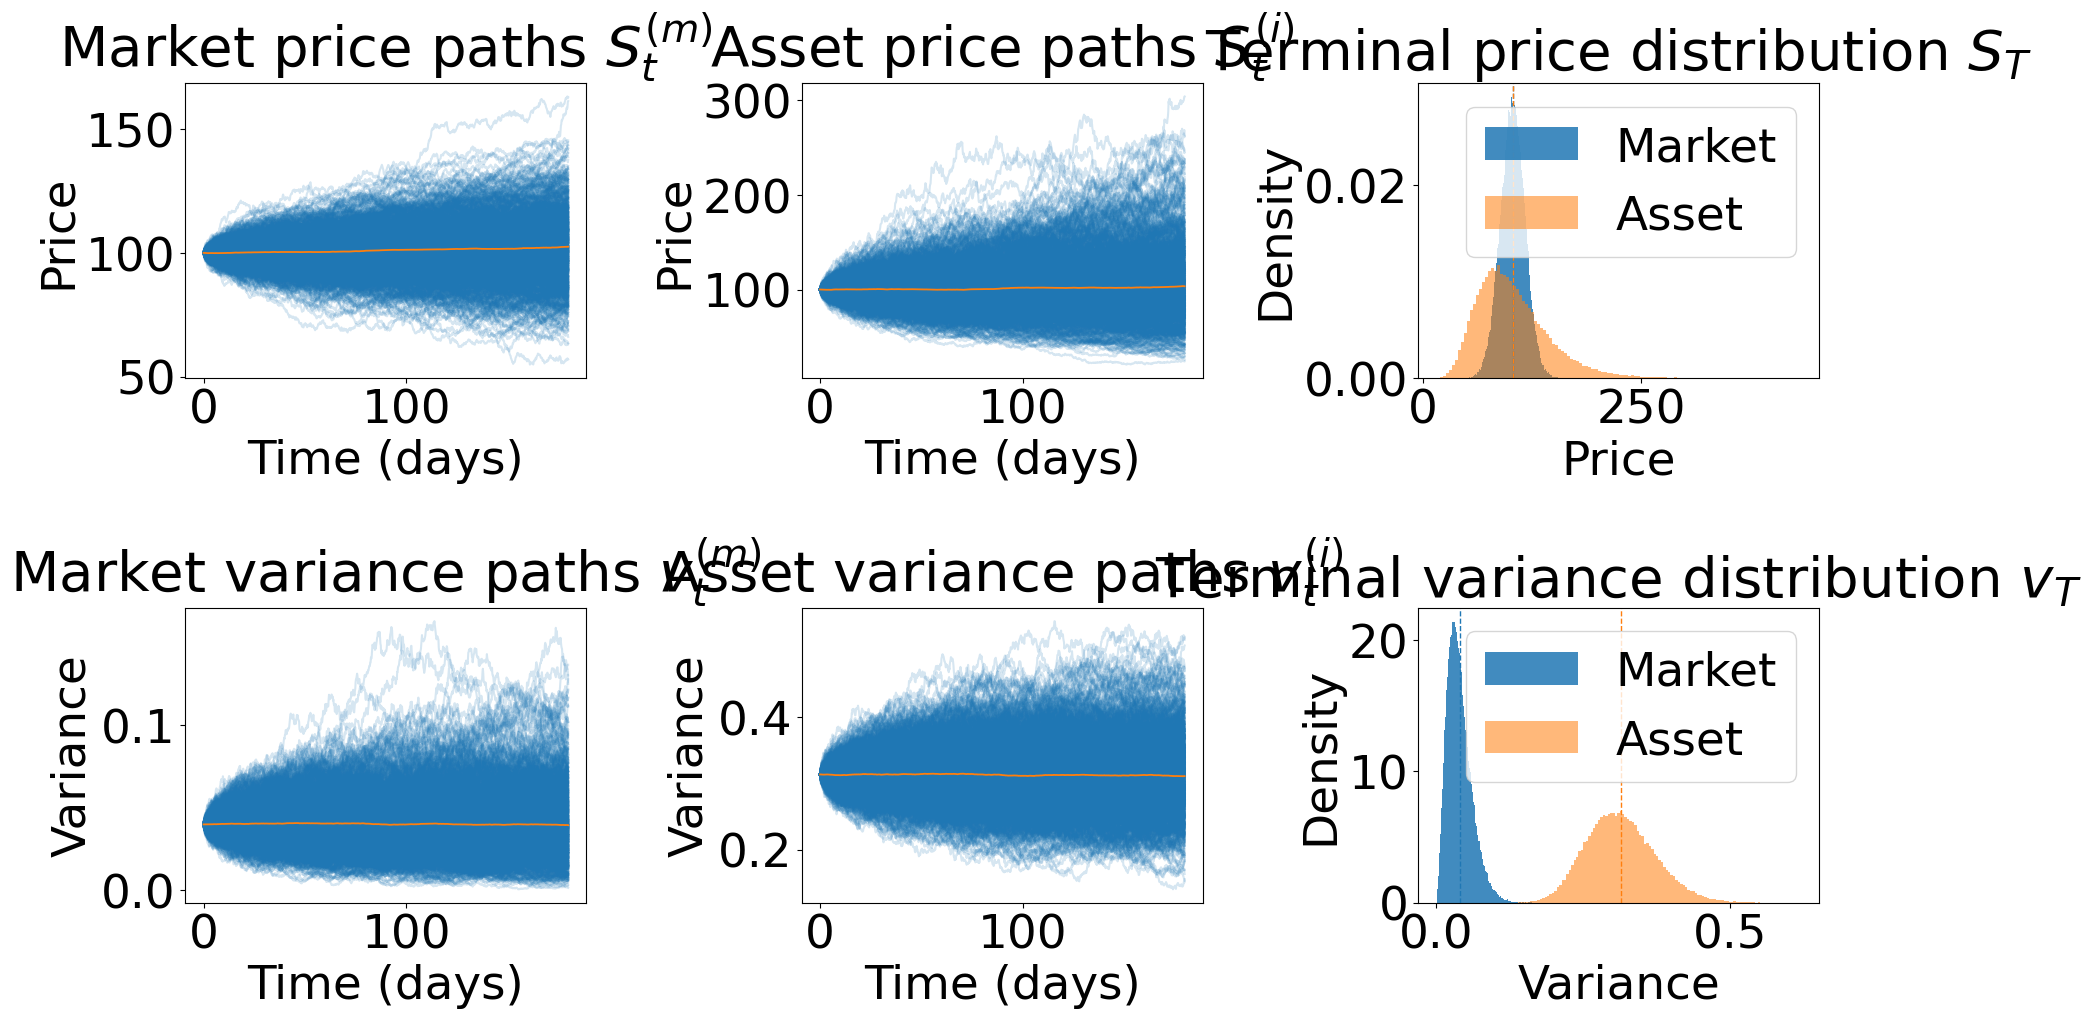

In [20]:
# -----------------------------------------------------------
# 1) PREPARE DATAFRAMES (only first 1 000 paths, to keep the
#    plot readable and memory-safe)
# -----------------------------------------------------------
n_show   = 1_000
idx_days = np.linspace(0, T*365, N+1)   # length N+1 = 1,001 here

df_Sm = pd.DataFrame(S_m[:, :n_show], index=idx_days)
df_Si = pd.DataFrame(S_i[:, :n_show], index=idx_days)
df_vm = pd.DataFrame(v_m[:, :n_show], index=idx_days)
df_vi = pd.DataFrame(v_i[:, :n_show], index=idx_days)

import matplotlib as mpl
mpl.rcParams["font.size"]   = mpl.rcParams["font.size"] * 1.5

# -----------------------------------------------------------
# 2) BUILD THE FIGURE
# -----------------------------------------------------------
bins = 120
fig, axs = plt.subplots(2, 3, figsize=(19, 11), tight_layout=True)

# --- price trajectories -------------------------------------------------
df_Sm.plot(legend=False, color="tab:blue", alpha=0.18, ax=axs[0, 0])
df_Sm.mean(axis=1).plot(ax=axs[0, 0], color="tab:orange", lw=1.3)
axs[0, 0].set(title="Market price paths $S^{(m)}_t$",
              xlabel="Time (days)", ylabel="Price")

df_Si.plot(legend=False, color="tab:blue", alpha=0.18, ax=axs[0, 1])
df_Si.mean(axis=1).plot(ax=axs[0, 1], color="tab:orange", lw=1.3)
axs[0, 1].set(title="Asset price paths $S^{(i)}_t$",
              xlabel="Time (days)", ylabel="Price")

# --- histogram of terminal prices --------------------------------------
_Sm_T = S_m[-1, :]
_Si_T = S_i[-1, :]

axs[0, 2].hist(_Sm_T, bins=bins, alpha=0.85, label="Market", density=True)
axs[0, 2].hist(_Si_T, bins=bins, alpha=0.55, label="Asset",  density=True)
axs[0, 2].axvline(_Sm_T.mean(), color="tab:blue",   ls="--", lw=1)
axs[0, 2].axvline(_Si_T.mean(), color="tab:orange", ls="--", lw=1)
axs[0, 2].set(title="Terminal price distribution $S_T$", xlabel="Price",
              ylabel="Density")
axs[0, 2].legend()

# --- volatility trajectories -------------------------------------------
df_vm.plot(legend=False, color="tab:blue", alpha=0.18, ax=axs[1, 0])
df_vm.mean(axis=1).plot(ax=axs[1, 0], color="tab:orange", lw=1.3)
axs[1, 0].set(title="Market variance paths $v^{(m)}_t$",
              xlabel="Time (days)", ylabel="Variance")

df_vi.plot(legend=False, color="tab:blue", alpha=0.18, ax=axs[1, 1])
df_vi.mean(axis=1).plot(ax=axs[1, 1], color="tab:orange", lw=1.3)
axs[1, 1].set(title="Asset variance paths $v^{(i)}_t$",
              xlabel="Time (days)", ylabel="Variance")

# --- histogram of terminal variances -----------------------------------
_vm_T = v_m[-1, :]
_vi_T = v_i[-1, :]

axs[1, 2].hist(_vm_T, bins=bins, alpha=0.85, label="Market", density=True)
axs[1, 2].hist(_vi_T, bins=bins, alpha=0.55, label="Asset",  density=True)
axs[1, 2].axvline(_vm_T.mean(), color="tab:blue",   ls="--", lw=1)
axs[1, 2].axvline(_vi_T.mean(), color="tab:orange", ls="--", lw=1)
axs[1, 2].set(title="Terminal variance distribution $v_T$", xlabel="Variance",
              ylabel="Density")
axs[1, 2].legend()

plt.show()


In [19]:
from scipy.stats import gamma

# 1) Quick summary statistics
print("Mean v_m  (simulated):", _vm_T.mean())
print("Mean v_i  (simulated):", _vi_T.mean())
print("theta_m (target mean):", theta_m)
print("theta_i (target mean):", theta_i)

# 2) Overlay the analytical stationary pdf of the CIR process
def cir_stationary_pdf(x, kappa, theta, sigma):
    c = 2*kappa/sigma**2
    d = 2*kappa*theta/sigma**2
    return gamma.pdf(x, d, scale=1/c)

x_vals = np.linspace(0, np.quantile(np.concatenate([_vm_T, _vi_T]), 0.995), 500)
axs[1, 2].plot(x_vals,
               cir_stationary_pdf(x_vals, kappa_m, theta_m, sigma_m),
               lw=2, color="tab:blue")
axs[1, 2].plot(x_vals,
               cir_stationary_pdf(x_vals, kappa_i, theta_i, sigma_i),
               lw=2, color="tab:orange")


Mean v_m  (simulated): 0.04003328105559785
Mean v_i  (simulated): 0.31354283558469476
theta_m (target mean): 0.04
theta_i (target mean): 0.3136


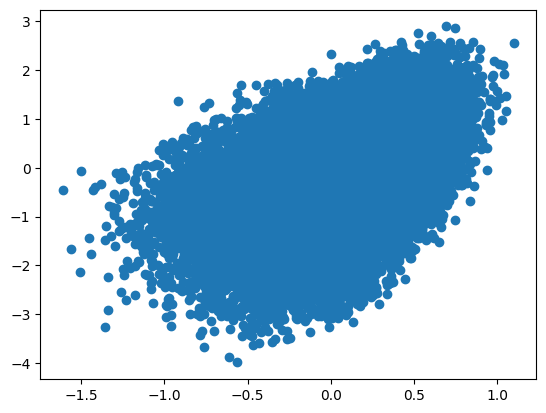

In [ ]:
plt.plot(total_r_m, total_r_i, 'o', label='Data')

# Looping

In [ ]:
# Set random seed for reproducibility
np.random.seed(47)

results = []

for beta in np.arange(0.1, 2, 0.1):
  for corr_m_i_set in np.arange (0.1, 1, 0.1):
    # Simulation parameters:
    r = 0.05
    T = 180/365        # roughly half a year
    N = 500             # number of time steps (finer grid helps reduce discretization error)
    M = 50000          # number of simulation paths

    # Market parameters:
    S0_m = 100.0
    v0_m = 0.04         # initial variance (e.g. 0.20^2 = 0.04)
    rho_m = -0.5
    kappa_m = 2.0
    theta_m = 0.04      # long-term variance (here 0.20^2 = 0.04)
    sigma_m = 0.225

    # Asset parameters:
    S0_i = 100.0
    beta_target = beta
    corr_m_i = corr_m_i_set
    # Back out asset's long-term variance:
    theta_i_computed = theta_m * (beta_target / corr_m_i)**2
    v0_i = theta_i_computed  # start the asset at its long-term variance
    rho_i = -0.5
    kappa_i = 2.0
    sigma_i = 0.225

    # Run the joint simulation:
    S_m, v_m, S_i, v_i, theta_i = joint_heston_sim(
        S0_m, S0_i, v0_m, v0_i,
        rho_m, kappa_m, theta_m, sigma_m,
        rho_i, kappa_i, sigma_i, beta_target, corr_m_i,
        r, T, N, M
    )

    total_r_m = np.log(S_m[-1, :] / S_m[0, :])
    total_r_i = np.log(S_i[-1, :] / S_i[0, :])
    total_r_residuals = total_r_i - beta_target * total_r_m

    X = sm.add_constant(total_r_m)  # Adds a constant column to total_r_m
    y = total_r_i
    model = sm.OLS(y, X)
    reg_output = model.fit()
    mean_beta = reg_output.params[1]
    std_beta = reg_output.bse[1]

    sd_m = np.std(total_r_m) * ((1/T) ** 0.5)
    sd_i = np.std(total_r_i) * ((1/T) ** 0.5)
    sd_e = np.std(total_r_residuals) * ((1/T) ** 0.5)
    skew_m = skew(total_r_m)
    skew_i = skew(total_r_i)
    skew_e = skew(total_r_residuals)

    beta_full = (skew_i / skew_m * (sd_i / sd_m)**3 - skew_e / skew_m * (sd_e / sd_m)**3 ) ** (1/3)

    corr_oi = (skew_i / skew_m)**(1/3)
    beta_oi = (skew_i / skew_m)**(1/3)*sd_i/sd_m

    curr_results = [beta, corr_m_i_set, theta_i**0.5, mean_beta, std_beta, sd_m, sd_i, sd_e, skew_m, skew_i, skew_e, corr_oi, beta_oi, beta_full]

    results.append(curr_results)

<ipython-input-3-ce200d2b4834>:50: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = np.random.multivariate_normal(mean, cov_matrix, M)  # shape (M, 4)
<ipython-input-40-53f16987dd8f>:59: RuntimeWarning: invalid value encountered in scalar power
  beta_full = (skew_i / skew_m * (sd_i / sd_m)**3 - skew_e / skew_m * (sd_e / sd_m)**3 ) ** (1/3)


In [ ]:
df = pd.DataFrame(results)  # Convert to DataFrame

# Define column names (optional but recommended)
column_names = ['beta', 'corr_m_i_set', 'theta_i_sqrt', 'mean_beta', 'std_beta',
                'sd_m', 'sd_i', 'sd_e', 'skew_m', 'skew_i', 'skew_e',
                'corr_oi', 'beta_oi', 'beta_full']
df.columns = column_names

# Export to Excel
df.to_excel('simulation_results.xlsx', index=False)